# Batch growth on a mix of polysaccharides

In [1]:
import pandas as pd
import numpy as np
import copy
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec

import cobra
import reframed
import molmass
import sys
import seaborn as sns
from os import listdir

sys.path.append("../functions/")

%load_ext autoreload
%autoreload 2


import dfba_cobra_multiple_polysaccharides




In [2]:
%run ../scripts/polysaccharide_monosaccharide_composition.py

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-27


### Wheat straw: A source of arabinoxylan

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()

model = dfba_cobra_multiple_polysaccharides.read_model(media)

**Determine weight fraction of each monosaccharide in each polysaccharide**

Assumption: A polysaccharide is degraded so that we have equal mol of carbon from each oligosaccharide. 

In [4]:
polysac_weight_frac = pd.read_csv("../input/polysaccharide_monosaccharide_weight_fractions.tsv",sep="\t",index_col=0)

# Add requirement for fraction of cellulose
polysac_weight_frac = polysac_weight_frac.T

polysac_weight_frac["Cellulose content"] = [0,0,1,0]
polysac_weight_frac["Xyloglucan content"] = [0,1,0,0]
polysac_weight_frac = polysac_weight_frac.T
polysac_weight_frac

,EX_arabinoxylan_e,EX_xyloglucan_e,EX_cellulose_e,EX_xylan_e
Glucose,0.000000,0.571704,1.0,0.000000
Xylose,0.696667,0.327903,0.0,0.877324
Galactose,0.000000,0.100392,0.0,0.000000
Arabinose,0.303333,0.000000,0.0,0.000000
Glucuronic acid,0.000000,0.000000,0.0,0.122676
Cellulose content,0.000000,0.000000,1.0,0.000000
Xyloglucan content,0.000000,1.000000,0.0,0.000000


**Determine mol of each polysaccharide needed to achieve the polysaccharide concentration**

In [5]:
desired_ratio_mol_dict = {"Glucose":45,
                    "Xylose":43.6,
                    "Galactose": 1.34,
                    "Arabinose":6.0,
                    "Glucuronic acid":3.9}

desired_ratio_cell = 27.30/(41.7+27.30)


In [6]:
desired_ratio_g =np.array([mol_frac*molmass.Formula(model.metabolites.get_by_id(dfba_cobra_multiple_polysaccharides.name2id[met_name]).notes["FORMULA"]).mass   
    for met_name,mol_frac in desired_ratio_mol_dict.items()])

# Desired weight ratio between the different monosaccharides
desired_ratio_ww = desired_ratio_g/sum(desired_ratio_g)
desired_ratio = desired_ratio_ww

# Desired ratio of different polysaccharides
desired_ratio = np.append(desired_ratio,desired_ratio_cell) # Cellulose
desired_ratio = np.append(desired_ratio,0) # Xyloglucan
# Least squares to get an approximate composition
polysac = np.dot(np.linalg.pinv(polysac_weight_frac.to_numpy()),desired_ratio.transpose())

polysac = polysac/sum(polysac)

In [7]:
pd.DataFrame({"Fitted weight ratio of polysaccharides":dict(zip(polysac_weight_frac.columns,polysac))})

,Fitted weight ratio of polysaccharides
EX_arabinoxylan_e,0.182430
EX_cellulose_e,0.464627
EX_xylan_e,0.327469
EX_xyloglucan_e,0.025474


**The monosaccharide composition in our model is relatively close to the actual sugar composition**

In [8]:
pd.DataFrame({"Desired weight ratio":dict(zip(polysac_weight_frac.index,desired_ratio)),
"Fitted weight ratio":dict(zip(polysac_weight_frac.index,np.dot(polysac_weight_frac.to_numpy(),polysac)))})

,Desired weight ratio,Fitted weight ratio
Glucose,0.489907,0.479190
Xylose,0.395554,0.422743
Galactose,0.014588,0.002557
Arabinose,0.054434,0.055337
Glucuronic acid,0.045517,0.040172
Cellulose content,0.395652,0.464627
Xyloglucan content,0.000000,0.025474


### Simulation

In [9]:
# The oligosaccharide composition of each polysaccharide

glc_eq_poly_dict =OrderedDict({"EX_arabinoxylan_e":{
"EX_AX_e": 15/6,
"EX_AXX_e": 20/6,
"EX_A23XX_e": 25/6,
"EX_XAXX_e": 25/6,
"EX_XA23XX_e": 30/6},
                              
"EX_xyloglucan_e":{                              
"EX_QLQG_e": 45/6,
"EX_QQLG_e":45/6,
"EX_QLLG_e":51/6,
"EX_QQQG_e":39/6,
"EX_GQQG_e":34/6},

"EX_cellulose_e":{"EX_cellb_e": 2,
"EX_cell3_e": 3,
"EX_cell4_e": 4,
"EX_cell5_e":5},
                               
"EX_xylan_e":{
"EX_xylb_e":10/6,
"EX_xyl3_e":15/6,
"EX_xylan4_e":26/6,
"EX_xylan8_e":52/6}

})

C_dict =OrderedDict()
C_dict["Growth"]=0.1
for rxns in glc_eq_poly_dict.values(): 
    for rxn in rxns: C_dict[rxn]=0
C_dict["EX_ac_e"]=0
C_dict["EX_co2_e"]=0

#polysac #EX_arabinoxylan_e	EX_xyloglucan_e	EX_cellulose_e	EX_xylan_e
C_dict["EX_arabinoxylan_e"]= polysac[0]*100
C_dict["EX_xyloglucan_e"]= polysac[1]*100
C_dict["EX_cellulose_e"]= polysac[2]*100
C_dict["EX_xylan_e"]= polysac[3]*100

rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max"]
best_r2 = {}

In [10]:
pd.Series({(poly[3].upper()+poly[4:-2],oligo[3].upper() + oligo[4:-2]):stoich 
 for poly,sub_dict in glc_eq_poly_dict.items()
 for oligo,stoich in sub_dict.items()}).to_csv("../../oligosaccharide_stoich.tsv",sep="\t")

In [11]:
%%time
C_results_tot = dfba_cobra_multiple_polysaccharides.multiple_polysaccharide_simulation([10, 1, 4/4,5], 
                                                     model,
                                                    media,
                                                    rxns,
                                                    y0,
                                                    objective_dir,
                                                    glc_eq_poly_dict,
                                                    t_end=120)

Lack of xyloglucan: -0.0005163846382602484
Lack of xyloglucan: -0.0005163846382602484
Lack of xyloglucan: -2.985548732054727e-05
Lack of xyloglucan: -6.449116761453322e-11
Lack of xyloglucan: -1.3877787807814457e-16
Lack of xyloglucan: -3.469446951953614e-18
CPU times: user 2min 3s, sys: 13.7 s, total: 2min 17s
Wall time: 2min 5s


In [12]:
color_poly_dict = OrderedDict({'EX_arabinoxylan_e':["lightblue","tab:blue","blue","darkblue","#02022e"],
              'EX_xyloglucan_e':["pink","tab:red","red","darkred","brown"],
              'EX_cellulose_e':["lightgreen","#60bf68","green","#223624"],
              'EX_xylan_e':["yellow","#fcdb03","#fcba03","#e67802"]})

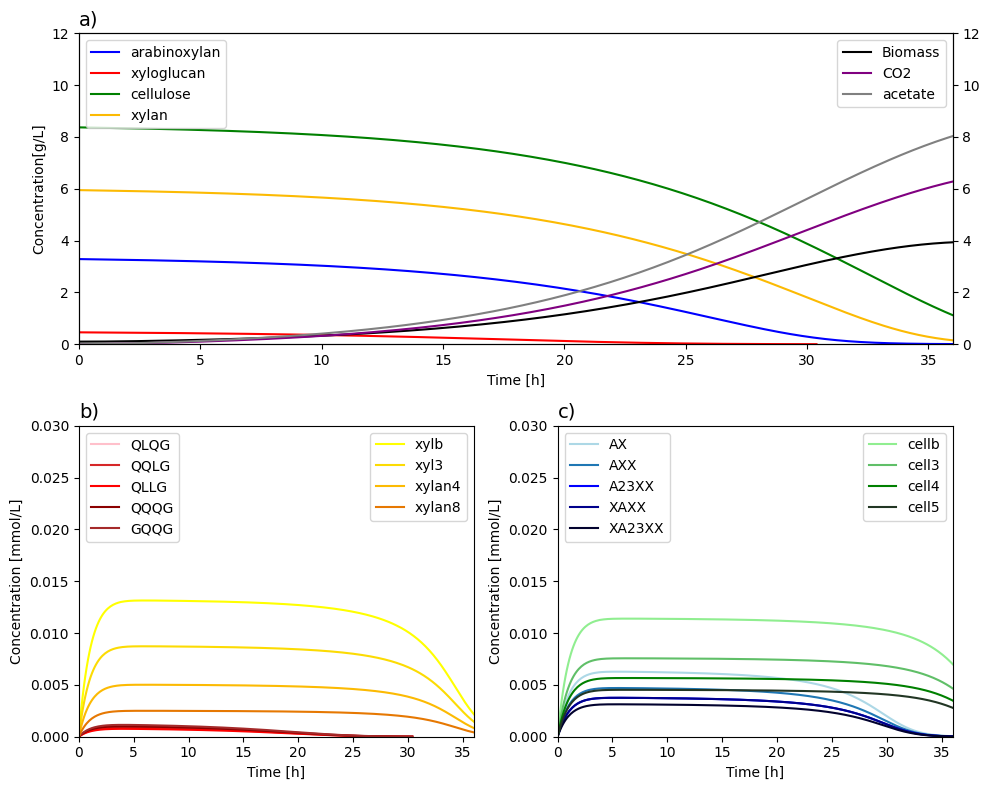

In [13]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(8,4,figure=fig)
ax1 = fig.add_subplot(gs[ -4:,0:2])
ax2 = fig.add_subplot(gs[-4:,2: ])
ax3 = fig.add_subplot(gs[:-4,0:])

artists = {}
for polysac_id,color_list in color_poly_dict.items():
    if polysac_id in ["EX_xylan_e","EX_xyloglucan_e"]:
        ax = ax1
    elif polysac_id in ["EX_cellulose_e","EX_arabinoxylan_e"]:
        ax = ax2
    
    artists[polysac_id] = []
    for i,oligosacc_id in enumerate(glc_eq_poly_dict[polysac_id].keys()):
        artist = ax.plot(C_results_tot[oligosacc_id]["t"],np.array(C_results_tot[oligosacc_id]["C"]),color=color_list[i],label=f"{oligosacc_id[3:-2]}")
        artists[polysac_id].extend(artist)
    polysac_g = monosac_comp_g[monosac_comp_g.index.isin(oligosac_fracs[polysac_id].keys())].sum().sum()
    ax3.plot(C_results_tot[polysac_id]["t"],np.array(C_results_tot[polysac_id]["C"])*polysac_g/1000,color=color_list[2],label=polysac_id[3:-2])

ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Concentration[g/L]")
ax3.set_ylim([0,12])
ax3.set_xlim([0,36])
ax3.legend(loc="upper left")
ax3.set_title("a)",loc="left",fontsize=14)

ax3_twin = ax3.twinx()
ax3_twin.plot(C_results_tot["Growth"]["t"],C_results_tot["Growth"]["C"],color="black",label="Biomass")
ax3_twin.plot(C_results_tot["EX_co2_e"]["t"],np.array(C_results_tot["EX_co2_e"]["C"])*molmass.Formula(model.metabolites.co2_e.formula).mass/1000,label="CO2",color="purple")
ax3_twin.plot(C_results_tot["EX_ac_e"]["t"],np.array(C_results_tot["EX_ac_e"]["C"])*molmass.Formula(model.metabolites.ac_e.formula).mass/1000,label="acetate",color="grey")


ax3_twin.set_ylim([0,12])
ax3_twin.legend(loc="upper right")

    
ax1.set_ylim([0,0.03])
ax1.set_xlim([0,36])
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Concentration [mmol/L]")
xylan_legend = ax1.legend(handles=artists["EX_xylan_e"],loc='upper right')
xylogluc_legend = ax1.legend(handles=artists["EX_xyloglucan_e"],loc='upper left')
ax1.add_artist(xylan_legend)
ax1.set_title("b)",loc="left",fontsize=14)

ax2.set_ylim([0,0.03])
ax2.set_xlim([0,36])
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Concentration [mmol/L]")
cellulose_legend = ax2.legend(handles=artists["EX_cellulose_e"],loc='upper right')
xylogluc_legend = ax2.legend(handles=artists["EX_arabinoxylan_e"],loc='upper left')
ax2.add_artist(cellulose_legend)

ax2.set_title("c)",loc="left",fontsize=14)

plt.tight_layout()

### 100 simulations with varying vmax and Km

**Load results**

In [14]:
dfs = []
for file in listdir("../results/multiple_polysacc_sensitivity/"):
    if file.endswith(".tsv"):
        df = pd.read_csv(f"../results/multiple_polysacc_sensitivity/{file}",sep="\t",index_col=None)
        dfs.append(df)
results_sensitivity = pd.concat(dfs)

#### Plot results

In [15]:
colors_bio = OrderedDict({"Growth":"black",
             "EX_co2_e":"purple",
             "EX_ac_e":"grey"})

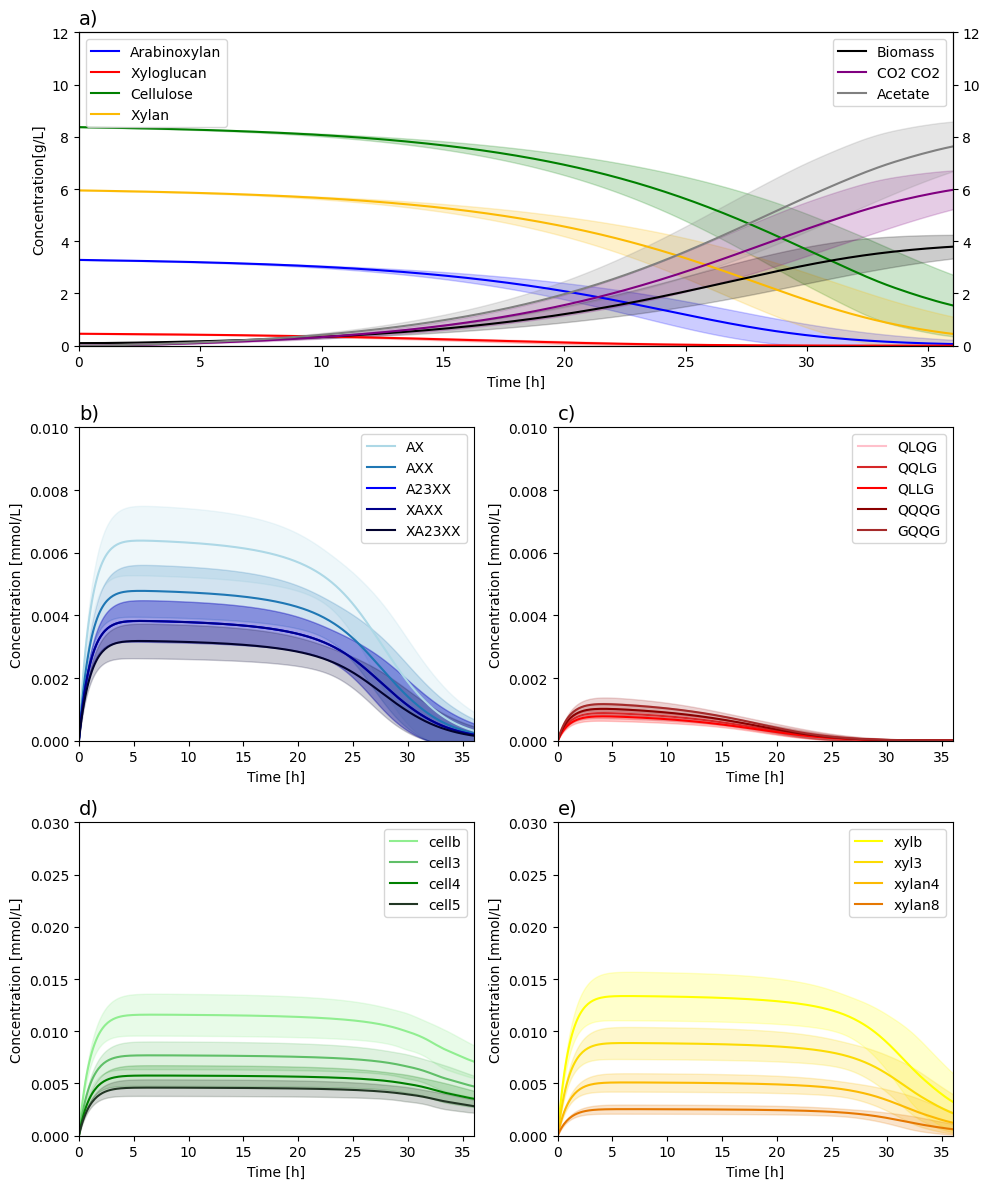

In [16]:
fig = plt.figure(figsize=(10,12))
gs = GridSpec(12,4,figure=fig)
ax1 = fig.add_subplot(gs[4:8,0:2])
ax2 = fig.add_subplot(gs[4:8,2: ])
ax3 = fig.add_subplot(gs[8:,0:2])
ax4 = fig.add_subplot(gs[8:,2: ])
ax_main = fig.add_subplot(gs[:4,0:])

# Polysaccharides and oligosaccharides
artists = {}
polysac_ids = []

polysac_ax = dict(zip(color_poly_dict.keys(),[ax1,ax2,ax3,ax4]))
polysac_title = dict(zip(color_poly_dict.keys(),["b)","c)","d)","e)"]))

errorbar = "sd"

for polysac_id,color_list in color_poly_dict.items():
    # Oligosaccharides...
    
    ax = polysac_ax[polysac_id]
    artists[polysac_id] = []
    
    oligosacc_ids = list(glc_eq_poly_dict[polysac_id].keys())
    colors_oligo = dict(zip(oligosacc_ids, color_list))
    subset_oligo = results_sensitivity[results_sensitivity.compound.isin(oligosacc_ids)].copy()
    num_lines_before = len(ax.lines)
    
    artist = sns.lineplot(ax=ax,
                          data=subset_oligo,
                          x="t", 
                          y="C",
                          hue="compound",
                          palette=colors_oligo,
                          hue_order=oligosacc_ids,
                          legend=False,
                          errorbar=errorbar)
    
    #... Rename labels for oligosaccharides
    new_lines = ax.lines[num_lines_before:]
    for line, label in zip(new_lines, oligosacc_ids):
        line.set_label(label[3:-2])
    artists[polysac_id].extend(new_lines)
    
    # Polysaccharides...
    polysac_g = monosac_comp_g[monosac_comp_g.index.isin(oligosac_fracs[polysac_id].keys())].sum().sum()
    subset_poly = results_sensitivity.query(f"compound=='{polysac_id}'").copy()
    subset_poly.C*=polysac_g/1000
    colors_poly = {polysac_id:color_list[2]}
    
    sns.lineplot(ax=ax_main, 
                 data=subset_poly,
                 x="t", 
                 y="C",
                 hue="compound",
                 palette=colors_poly,
                 legend=False,
                 errorbar=errorbar)
    
    polysac_ids.append(polysac_id)
    if polysac_id in ["EX_xyloglucan_e","EX_arabinoxylan_e"]:
        ax.set_ylim([0,0.01])
    else:
        ax.set_ylim([0,0.03])
    ax.set_xlim([0,36])
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Concentration [mmol/L]")
    
    oligo_legend = ax.legend(handles=artists[polysac_id],loc='upper right')
    ax.set_title(polysac_title[polysac_id],loc="left",fontsize=14)

#... Rename labels for polysaccharides
polysac_lines = ax_main.lines
for line, label in zip(polysac_lines, polysac_ids):
    line.set_label(label[3].upper() + label[4:-2])   
artists_poly = ax_main.lines.copy()


# Acetate, CO2 and biomass
ax_main_twin = ax_main.twinx()

bio_order = colors_bio.keys()

subset_bio = results_sensitivity[results_sensitivity.compound.isin(colors_bio.keys())].copy()
subset_bio.loc[subset_bio.compound=="EX_co2_e","C"]*=molmass.Formula(model.metabolites.co2_e.formula).mass/1000
subset_bio.loc[subset_bio.compound=="EX_ac_e","C"]*=molmass.Formula(model.metabolites.ac_e.formula).mass/1000
num_lines_before = len(ax_main.lines)
sns.lineplot(ax=ax_main, 
             data=subset_bio,
             x="t", 
             y="C",
             hue="compound",
             palette=colors_bio,
             legend=False,
             hue_order = bio_order,
             errorbar=errorbar)

bio_lines = ax_main.lines[num_lines_before:]
for line, label in zip(bio_lines, bio_order):
    if label=="Growth":
        line.set_label("Biomass")  
    else:
        line.set_label(model.metabolites.get_by_id(label[3:]).name)  
artists_bio = ax_main.lines[num_lines_before:]

# Fig settings and labels
    
ax_main.set_xlabel("Time [h]")
ax_main.set_ylabel("Concentration[g/L]")
ax_main.set_ylim([0,12])
ax_main.set_xlim([0,36])
poly_legend = ax_main.legend(handles=artists_poly,loc='upper left')

ax_main.set_title("a)",loc="left",fontsize=14)
ax_main_twin.set_ylim([0,12])
ax_main_twin.set_xlim([0,36])
bio_legend =ax_main_twin.legend(handles=artists_bio,loc='upper right')

plt.tight_layout()
plt.savefig("../figures/wheat_straw_simulation.tiff", format="tiff", dpi=300)